In [89]:
import json
import pandas as pd


In [98]:
df = pd.read_csv('AAPL_post_adjusted_data.csv')
df = df[2:]
df 

,Price,Close,High,Low,Open,Volume
2,1980-12-12,0.09872592240571976,0.0991551417254879,0.09872592240571976,0.09872592240571976,469033600
3,1980-12-15,0.09357534348964691,0.09400456286814542,0.09357534348964691,0.09400456286814542,175884800
4,1980-12-16,0.08670711517333984,0.08713632883986563,0.08670711517333984,0.08713632883986563,105728000
5,1980-12-17,0.08885320276021957,0.08928242219541198,0.08885320276021957,0.08885320276021957,86441600
6,1980-12-18,0.09142924100160599,0.09185845454209865,0.09142924100160599,0.09142924100160599,73449600
...,...,...,...,...,...,...
11141,2025-02-24,247.10000610351562,248.86000061035156,244.4199981689453,244.92999267578125,51326400
11142,2025-02-25,247.0399932861328,250.0,244.91000366210938,248.0,48013300
11143,2025-02-26,240.36000061035156,244.97999572753906,239.1300048828125,244.3300018310547,44433600
11144,2025-02-27,237.3000030517578,242.4600067138672,237.05999755859375,239.41000366210938,41153600


In [99]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

df['as_of_date'] = pd.to_datetime(df['Price'])
df = df.drop(columns = ['Price'])

df_final = df.sort_values(by='as_of_date')

In [100]:
df_final = df_final.rename(columns={
    "Open": "open",
    "Close": "close",
    "High": "high",
    "Low": "low",
    "Volume": "volume"
})

log_columns = ["open", "close", "high", "low", "volume"]

for col in log_columns:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')  
    df_final[col] = df_final[col].fillna(0) 
    df_final[f"log_{col}"] = np.log1p(df_final[col])

df_final.head()

,close,high,low,open,volume,as_of_date,log_open,log_close,log_high,log_low,log_volume
2,0.098726,0.099155,0.098726,0.098726,469033600,1980-12-12,0.094151,0.094151,0.094542,0.094151,19.966185
3,0.093575,0.094005,0.093575,0.094005,175884800,1980-12-15,0.089845,0.089452,0.089845,0.089452,18.985340
4,0.086707,0.087136,0.086707,0.087136,105728000,1980-12-16,0.083547,0.083152,0.083547,0.083152,18.476380
5,0.088853,0.089282,0.088853,0.088853,86441600,1980-12-17,0.085125,0.085125,0.085519,0.085125,18.274980
6,0.091429,0.091858,0.091429,0.091429,73449600,1980-12-18,0.087488,0.087488,0.087881,0.087488,18.112110


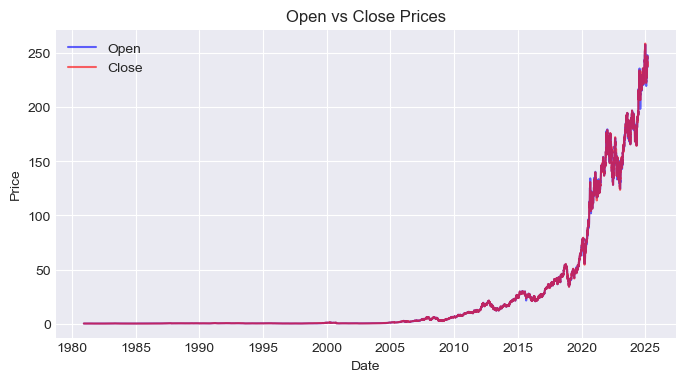

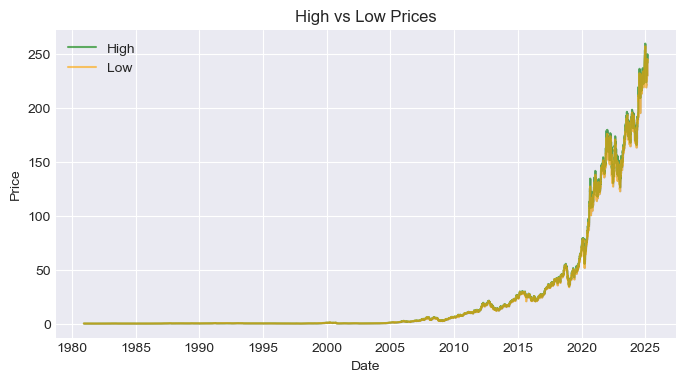

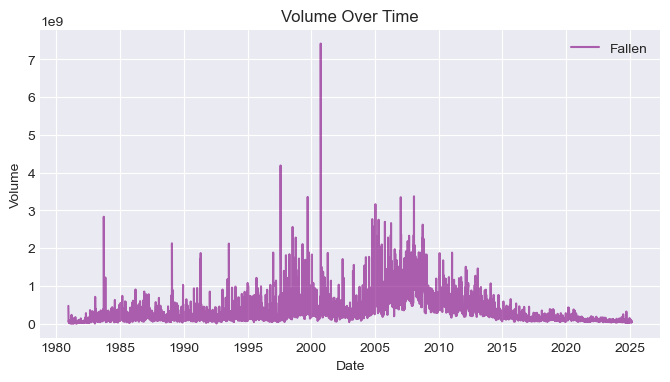

In [102]:
### original
df_ori = df_final[["as_of_date","open", "close", "high", "low", "volume"]].copy()


plt.style.use("seaborn-v0_8-dark")

plt.figure(figsize=(8, 4))
plt.plot(df_ori["as_of_date"], df_ori["open"], label="Open", color="blue", alpha=0.6)
plt.plot(df_ori["as_of_date"], df_ori["close"], label="Close", color="red", alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Open vs Close Prices")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df_ori["as_of_date"], df_ori["high"], label="High", color="green", alpha=0.6)
plt.plot(df_ori["as_of_date"], df_ori["low"], label="Low", color="orange", alpha=0.6)
plt.fill_between(df_ori["as_of_date"], df_ori["high"], df_ori["low"], color="gray", alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("High vs Low Prices")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df_ori["as_of_date"], df_ori["volume"], label="Fallen", color="purple", alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume Over Time")
plt.legend()
plt.grid()
plt.show()

In [106]:
# 计算 80% 分割点
split_idx = int(len(df_ori)*0.9)

# 划分训练集和测试集
train_df = df_ori.iloc[:split_idx].copy()
test_df = df_ori.iloc[split_idx:].copy()

print(len(train_df))
print(len(test_df))

10029
1115


### Brechmark- previous high / same day open

In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.metrics import r2_score
# 使用前一天的 High 作为预测值
y_test = df_ori['high']
prev_high_preds = np.roll(y_test, shift=1)  # 向右移动 1 步，模拟前一天的 high
y_test = y_test[split_idx-len(df_ori):]
prev_high_preds = prev_high_preds[split_idx-len(df_ori):]
print(len(y_test),len(prev_high_preds))

# 计算评估指标
mae_prev = mean_absolute_error(y_test, prev_high_preds)
rmse_prev = np.sqrt(mean_squared_error(y_test, prev_high_preds))
mape_prev = np.mean(np.abs((y_test - prev_high_preds) / y_test)) * 100
r2_prev = r2_score(y_test, prev_high_preds)

print(" Benchmark 1: Previous Day High")
print(f"MAE: {mae_prev:.4f}")
print(f"RMSE: {rmse_prev:.4f}")
print(f"MAPE: {mape_prev:.2f}%")
print(f"R² Score: {r2_prev:.4f}")

1115 1115
 Benchmark 1: Previous Day High
MAE: 1.8372
RMSE: 2.5207
MAPE: 1.12%
R² Score: 0.9948


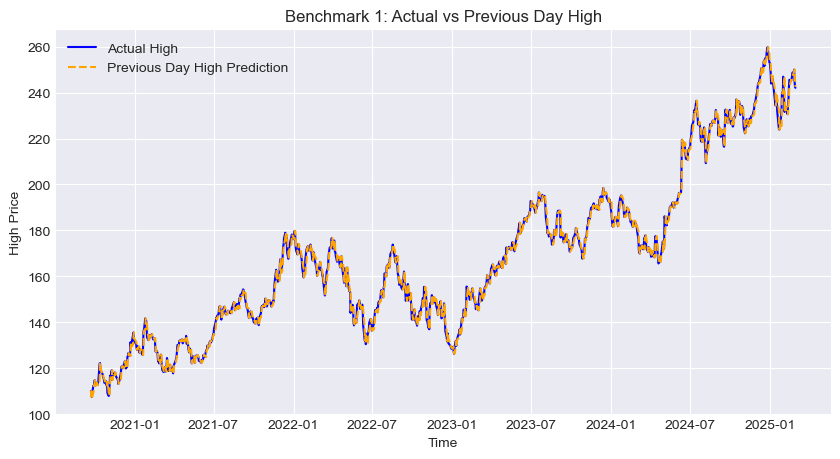

In [110]:
plt.figure(figsize=(10,5))
plt.plot(test_df["as_of_date"],y_test, label="Actual High", color="blue")
plt.plot(test_df["as_of_date"],prev_high_preds, label="Previous Day High Prediction", color="orange", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("High Price")
plt.title("Benchmark 1: Actual vs Previous Day High")
plt.legend()
plt.grid()
plt.show()

In [111]:
# 使用当日的 Open 作为 High 的预测值
same_open_preds = test_df["open"].values[:len(y_test)]  # 确保长度匹配

# 计算评估指标
mae_open = mean_absolute_error(y_test, same_open_preds)
rmse_open = np.sqrt(mean_squared_error(y_test, same_open_preds))
mape_open = np.mean(np.abs((y_test - same_open_preds) / y_test)) * 100
r2_open = r2_score(y_test, same_open_preds)

print(" Benchmark 2: Same Day Open")
print(f"MAE: {mae_open:.4f}")
print(f"RMSE: {rmse_open:.4f}")
print(f"MAPE: {mape_open:.2f}%")
print(f"R² Score: {r2_open:.4f}")

 Benchmark 2: Same Day Open
MAE: 1.7885
RMSE: 2.3733
MAPE: 1.08%
R² Score: 0.9954


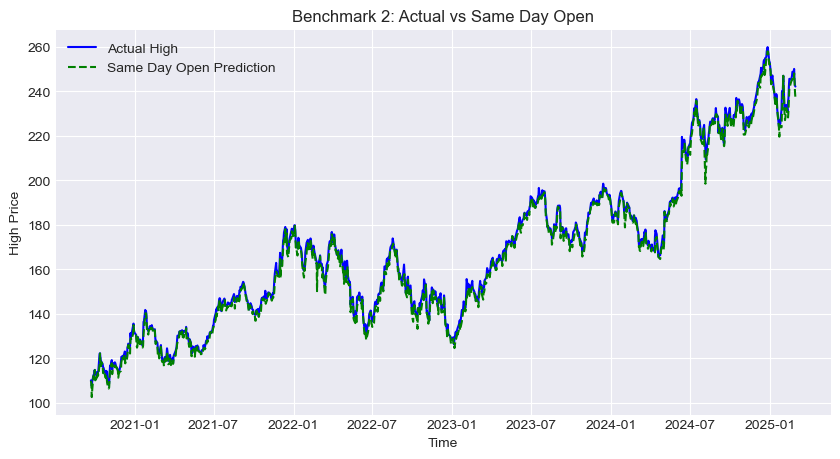

In [112]:
plt.figure(figsize=(10,5))
plt.plot(test_df["as_of_date"],y_test, label="Actual High", color="blue")
plt.plot(test_df["as_of_date"], same_open_preds, label="Same Day Open Prediction", color="green", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("High Price")
plt.title("Benchmark 2: Actual vs Same Day Open")
plt.legend()
plt.grid()
plt.show()

### Arima

In [113]:
from statsmodels.tsa.arima.model import ARIMA


# 训练 ARIMA 模型 (p, d, q 需要调整)
model = ARIMA(train_df["high"], order=(5,1,0))  # 5阶自回归, 1阶差分, 0阶移动平均
arima_model = model.fit()

# 预测
preds = arima_model.forecast(steps=len(test_df))

mae = mean_absolute_error(test_df["high"], preds)
rmse = np.sqrt(mean_squared_error(test_df["high"], preds))
mape = np.mean(np.abs((test_df["high"] - preds) / test_df["high"])) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")

r2 = r2_score(test_df["high"], preds)
print(f"R² Score: {r2:.4f}")

print(f"AIC: {arima_model.aic}")
print(f"BIC: {arima_model.bic}")

MAE: 61.28089799942817
RMSE: 70.62908164988639
MAPE: 33.80%
R² Score: -3.0461
AIC: 7408.540979989689
BIC: 7451.819798745358


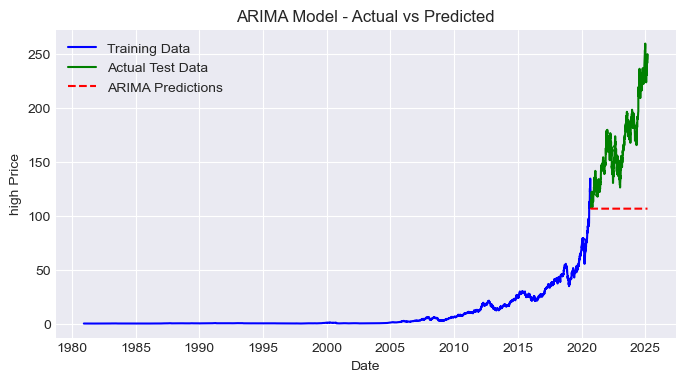

In [114]:
import matplotlib.pyplot as plt

# 画图对比真实值和预测值
plt.figure(figsize=(8,4))
plt.plot(train_df["as_of_date"], train_df["high"], label="Training Data", color="blue")
plt.plot(test_df["as_of_date"], test_df["high"], label="Actual Test Data", color="green")
plt.plot(test_df["as_of_date"], preds, label="ARIMA Predictions", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("high Price")
plt.title("ARIMA Model - Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()

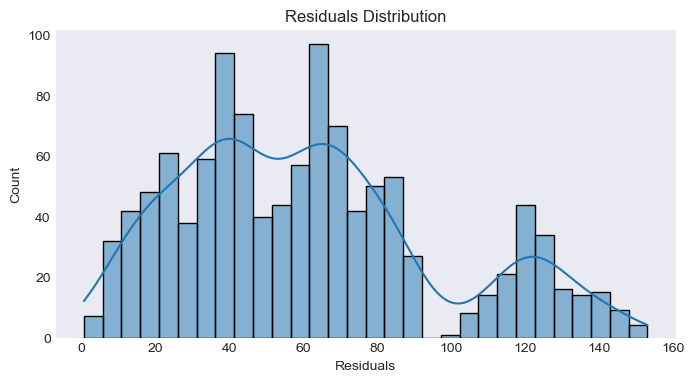

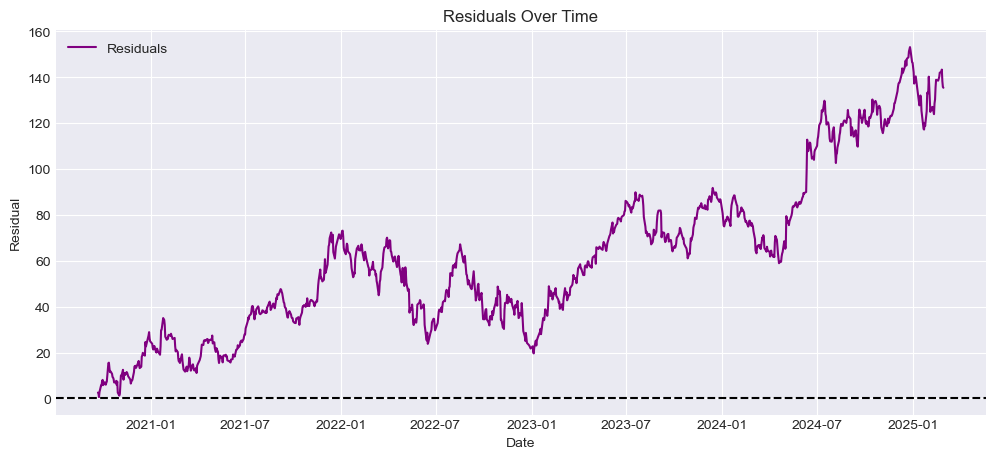

In [115]:
import seaborn as sns

# 计算残差
residuals = test_df["high"] - preds

# 残差分布图
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.show()

# 残差随时间变化
plt.figure(figsize=(12,5))
plt.plot(test_df["as_of_date"], residuals, label="Residuals", color="purple")
plt.axhline(y=0, color="black", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.title("Residuals Over Time")
plt.legend()
plt.grid()
plt.show()

# Prophet

In [117]:
from prophet import Prophet

# 创建 Prophet 模型
prophet_model = Prophet()
df_prophet = train_df[["as_of_date", "high"]].rename(columns={"as_of_date": "ds", "high": "y"})

prophet_model.fit(df_prophet)

# 预测
future = prophet_model.make_future_dataframe(periods=len(test_df))
forecast = prophet_model.predict(future)

'''
future = prophet_model.make_future_dataframe(periods=1500)  # 未来365天

future = future[future["ds"].isin(test_df["as_of_date"])]
forecast = prophet_model.predict(future)
'''

00:33:43 - cmdstanpy - INFO - Chain [1] start processing
00:33:44 - cmdstanpy - INFO - Chain [1] done processing


'\nfuture = prophet_model.make_future_dataframe(periods=1500)  # 未来365天\n\nfuture = future[future["ds"].isin(test_df["as_of_date"])]\nforecast = prophet_model.predict(future)\n'

In [118]:
# 1️⃣ 找到 Test 数据的第一个日期
start_date = test_df["as_of_date"].min()

# 2️⃣ 找到 `forecast` 里最接近 start_date 的索引
start_idx = forecast[forecast["ds"] >= start_date].index[0]

# 3️⃣ 取 `len(test_df)` 长度的数据
forecast_test = forecast.iloc[start_idx : start_idx + len(test_df)]

# 4️⃣ 确保 `y_true` 和 `y_pred` 长度一致
y_true = test_df["high"].values[:len(forecast_test)]
y_pred = forecast_test["yhat"].values

#y_true = test_df["high"].values
#y_pred = forecast["yhat"].values

# 5️⃣ 计算误差
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")

MAE: 92.44342328094801
RMSE: 97.03024150595888
MAPE: 53.86%


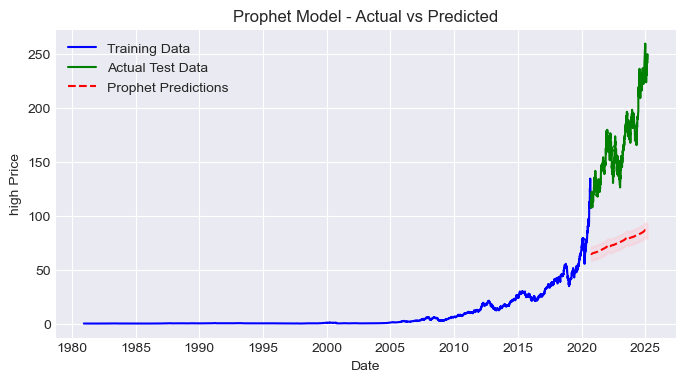

In [119]:
plt.figure(figsize=(8,4))
plt.plot(train_df["as_of_date"], train_df["high"], label="Training Data", color="blue")
plt.plot(test_df["as_of_date"], test_df["high"], label="Actual Test Data", color="green")
plt.plot(test_df["as_of_date"], forecast_test["yhat"], label="Prophet Predictions", color="red", linestyle="dashed")
plt.fill_between(test_df["as_of_date"], forecast_test["yhat_lower"], forecast_test["yhat_upper"], color="pink", alpha=0.3)  # 置信区间
plt.xlabel("Date")
plt.ylabel("high Price")
plt.title("Prophet Model - Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()

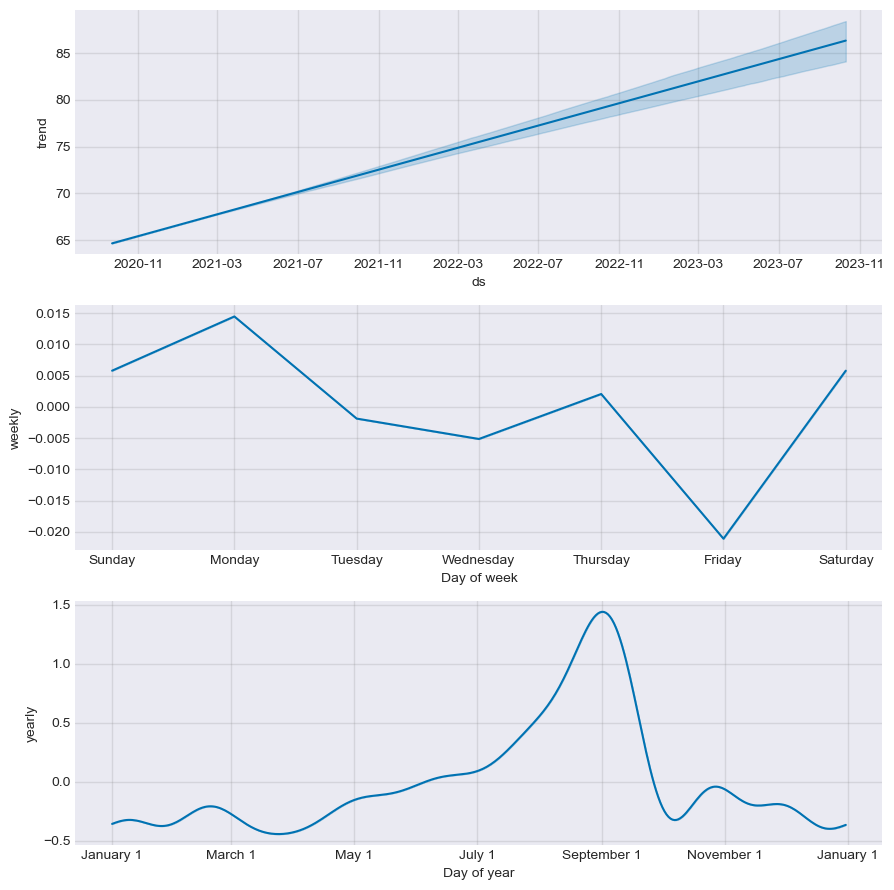

In [120]:
prophet_model.plot_components(forecast_test)
plt.show()

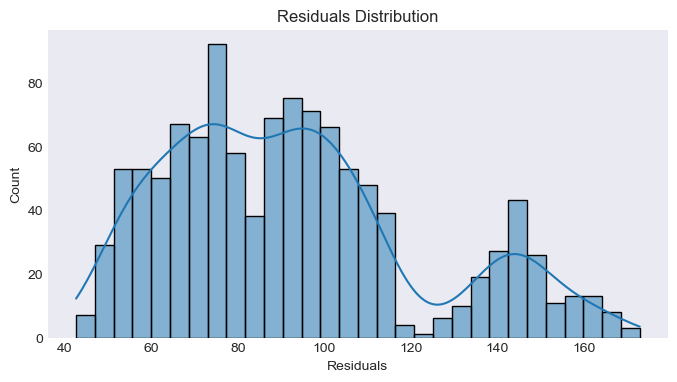

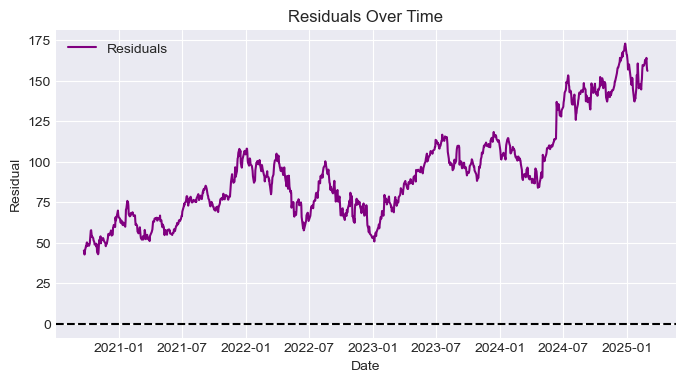

In [121]:
# 计算残差
residuals = y_true - y_pred

# 残差分布图
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.show()

# 残差随时间变化
plt.figure(figsize=(8,4))
plt.plot(test_df["as_of_date"], residuals, label="Residuals", color="purple")
plt.axhline(y=0, color="black", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.title("Residuals Over Time")
plt.legend()
plt.grid()
plt.show()

### VAR

In [122]:
from statsmodels.tsa.api import VAR

# 选择多个变量作为输入
var_data = train_df[["open", "close", "high", "low", "volume"]]

# 训练 VAR 模型（自动选择最佳滞后阶数）
model = VAR(var_data)
order = model.select_order(maxlags=10)  # 自动选择最优滞后阶
var_model = model.fit(order.aic)  # 使用 AIC 选择最佳模型

# 预测
preds = var_model.forecast(var_data.values[-order.aic:], steps=len(test_df))

# 转换为 DataFrame
preds_df = pd.DataFrame(preds, columns=["open_pred", "close_pred", "high_pred", "low_pred", "volume_pred"])
print(preds_df.head())

    open_pred  close_pred   high_pred    low_pred   volume_pred
0  108.338455  105.726694  109.813022  104.629340  1.914025e+08
1  105.957679  105.148140  107.142528  102.690406  1.309942e+08
2  103.674665  103.330487  105.646683  101.888213  1.016842e+08
3  103.165441  103.671440  105.501106  101.499414  1.159749e+08
4  103.858008  104.497127  105.891260  102.500584  1.324248e+08


In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 确保预测数据的索引匹配测试集
y_true = test_df[["open", "close", "high", "low", "volume"]].values
y_pred = preds  # VAR 预测的结果

# 计算误差
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

MAE: 59075514.54475318
RMSE: 157535656.94662747
MAPE: 122.03%
R² Score: -23.9309


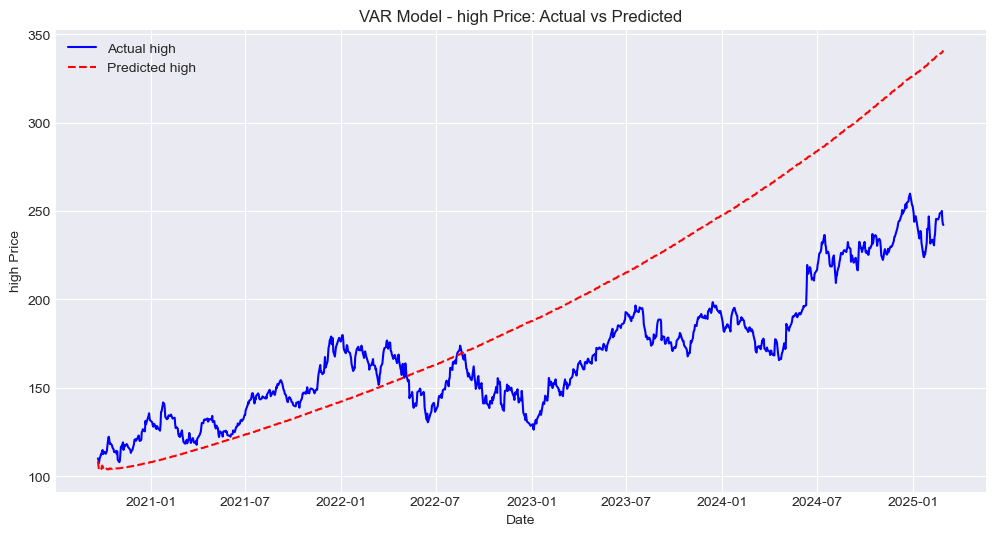

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# 绘制 high 价格
plt.plot(test_df["as_of_date"], test_df["high"], label="Actual high", color="blue")
plt.plot(test_df["as_of_date"], preds[:, 0], label="Predicted high", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("high Price")
plt.title("VAR Model - high Price: Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()

### SARIMAX

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40153D-02    |proj g|=  8.42022D-01

At iterate    5    f= -5.61532D-02    |proj g|=  1.44527D-01

At iterate   10    f= -8.95212D-02    |proj g|=  1.07468D-01

At iterate   15    f= -9.01222D-02    |proj g|=  3.49264D-03

At iterate   20    f= -9.01242D-02    |proj g|=  1.15965D-03

At iterate   25    f= -9.01243D-02    |proj g|=  1.59057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     29      1     0     0   

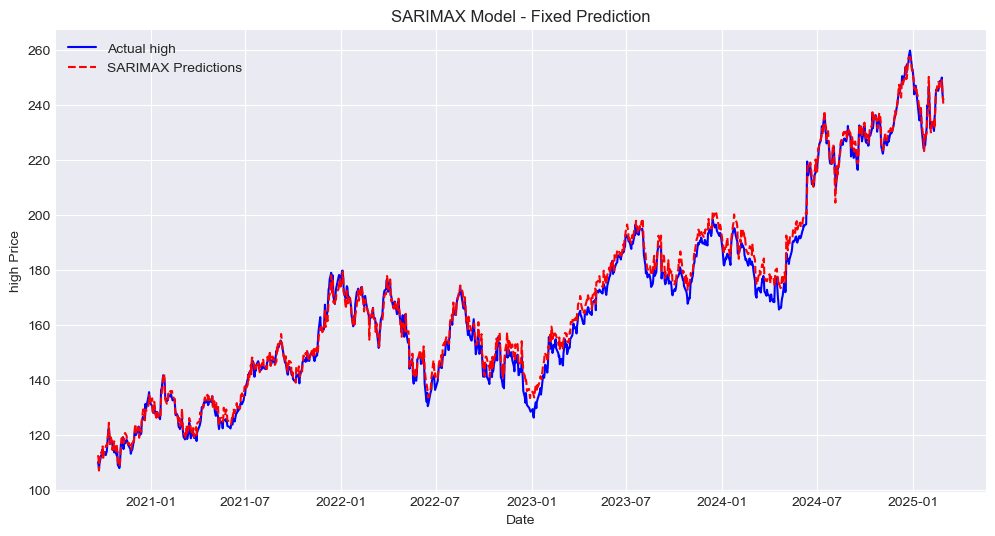

In [125]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 目标变量 (high)
y = train_df["high"]

# 选择外部变量 (Volume, High, Low)
X = train_df[["open"]]

# 训练 SARIMAX 模型
sarimax_model = SARIMAX(y, exog=X, order=(5,1,0), seasonal_order=(1,1,0,12))
sarimax_result = sarimax_model.fit()

# 预测
X_test = test_df[["open"]]  # 使用 Test 集的外部变量
#preds = sarimax_result.predict(start=len(y), end=len(y) + len(test_df) - 1, exog=X_test)

# 结果转换为 DataFrame
#preds_df = pd.DataFrame({"date": test_df["as_of_date"], "high": preds})
#print(preds_df.head())


y_pred = sarimax_result.forecast(steps=len(test_df),exog=X_test)

# 画图
plt.figure(figsize=(12,6))
plt.plot(test_df["as_of_date"], test_df["high"], label="Actual high", color="blue")
plt.plot(test_df["as_of_date"], y_pred, label="SARIMAX Predictions", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("high Price")
plt.title("SARIMAX Model - Fixed Prediction")
plt.legend()
plt.grid()
plt.show()

In [126]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 确保 y_true 和 y_pred 对齐
y_true = test_df["high"].values

# 计算误差
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

MAE: 2.6095674125823587
RMSE: 3.2323230095657443
MAPE: 1.61%
R² Score: 0.9915


### Dynamic Regression


In [127]:
train_df

,as_of_date,open,close,high,low,volume
2,1980-12-12,0.098726,0.098726,0.099155,0.098726,469033600
3,1980-12-15,0.094005,0.093575,0.094005,0.093575,175884800
4,1980-12-16,0.087136,0.086707,0.087136,0.086707,105728000
5,1980-12-17,0.088853,0.088853,0.089282,0.088853,86441600
6,1980-12-18,0.091429,0.091429,0.091858,0.091429,73449600
...,...,...,...,...,...,...
10026,2020-09-15,115.383429,112.662903,115.870978,110.780962,184642000
10027,2020-09-16,112.360642,109.337830,113.111465,109.250074,154679000
10028,2020-09-17,106.987836,107.592392,109.406076,106.002984,178011000
10029,2020-09-18,107.650923,104.179565,108.118966,103.448241,287104900


In [128]:
import statsmodels.api as sm

# 目标变量
y = train_df["high"]

# 特征变量：滞后变量 & 外部变量
X = train_df[["open"]].copy()
X["low_lag1"] = train_df["low"].shift(1)
X["close_lag1"] = train_df["close"].shift(1)
X["volume_lag1"] = train_df["volume"].shift(1)
X = X.dropna()

# 重新对齐 y
y = y[X.index]

# 训练回归模型
X = sm.add_constant(X)  # 添加截距项
model = sm.OLS(y, X).fit()

# 预测
X_test = test_df[["open"]].copy()
X_test["low_lag1"] = test_df["low"].shift(1)
X_test["close_lag1"] = test_df["close"].shift(1)
X_test["volume_lag1"] = test_df["volume"].shift(1)
X_test = sm.add_constant(X_test.dropna())

preds = model.predict(X_test)

# 结果 DataFrame
preds_df = pd.DataFrame({"date": test_df["as_of_date"], "high_pred": preds})
print(preds_df.head())

            date   high_pred
10031 2020-09-22         NaN
10032 2020-09-23  110.321256
10033 2020-09-24  103.840180
10034 2020-09-25  107.216641
10035 2020-09-28  113.587735


In [129]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = test_df["high"].iloc[1:].values
# 计算误差
mae = mean_absolute_error(y_true, preds)
rmse = np.sqrt(mean_squared_error(y_true, preds))
mape = np.mean(np.abs((y_true - preds) / y_true)) * 100
r2 = r2_score(y_true, preds)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

MAE: 1.1610803502745373
RMSE: 1.549193093663259
MAPE: 0.70%
R² Score: 0.9981


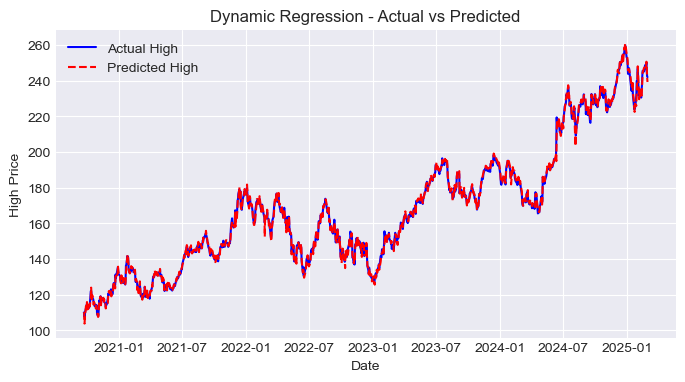

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(test_df["as_of_date"], test_df["high"], label="Actual High", color="blue")
plt.plot(test_df["as_of_date"].iloc[1:], preds, label="Predicted High", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("High Price")
plt.title("Dynamic Regression - Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()

### xgboost

In [137]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
train= df_ori.copy()

# 创建滞后特征
for lag in range(1, 5):  # 过去5天的特征
    train[f"high_lag{lag}"] = train["high"].shift(lag)

train["close_lag1"] = train["close"].shift(1)
train["low_lag1"] = train["low"].shift(1)
train["volume_lag1"] = train["volume"].shift(1)

# 处理数据
X = train.dropna().drop(columns=["as_of_date", "high","volume","low","close"])  # 特征
print(X.columns)
y = train.dropna()["high"]  # 目标变量

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=False)

# 训练 XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# 预测
preds = xgb_model.predict(X_valid)


Index(['open', 'high_lag1', 'high_lag2', 'high_lag3', 'high_lag4',
       'close_lag1', 'low_lag1', 'volume_lag1'],
      dtype='object')


In [138]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 计算误差
mae = mean_absolute_error(y_valid, preds)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
mape = np.mean(np.abs((y_valid - preds) / y_valid)) * 100
r2 = r2_score(y_valid, preds)

# 输出评估指标
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

MAE: 68.86615348734642
RMSE: 78.8816007181317
MAPE: 38.16%
R² Score: -4.0546


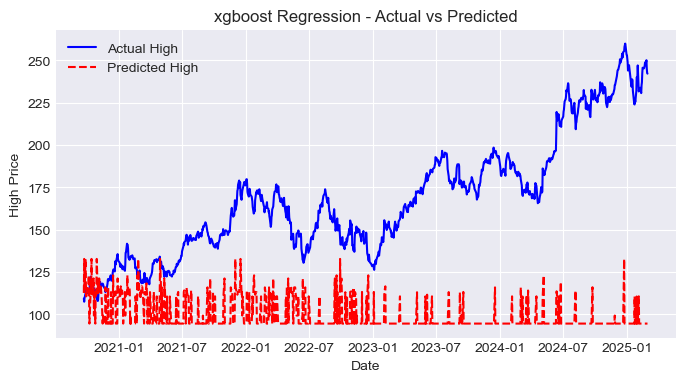

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(test_df.iloc[1:]["as_of_date"], y_valid, label="Actual High", color="blue")
plt.plot(test_df.iloc[1:]["as_of_date"], preds, label="Predicted High", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("High Price")
plt.title("xgboost Regression - Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()

### RNN

In [142]:
data= df_ori.copy().drop(columns=['as_of_date'])
train_df, test_df = train_test_split(data,test_size=0.1)
time_steps = 10

def create_sequences(data, target_col, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps].values)  # 过去 time_steps 个月的数据
        y.append(data.iloc[i+time_steps][target_col])  # 目标值
    return np.array(X), np.array(y)

# 重新生成 X_train 和 X_test
X_train, y_train = create_sequences(train_df, 'high', time_steps)
X_test, y_test = create_sequences(test_df, 'high', time_steps)

# 确保 X_train, X_test, y_train, y_test 都是 float32
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32).reshape(-1, 1)  # 确保 y_train 是 2D
y_test = np.array(y_test, dtype=np.float32).reshape(-1, 1)

# 打印数据类型以确认
print(f"X_train dtype: {X_train.dtype}, shape: {X_train.shape}")
print(f"y_train dtype: {y_train.dtype}, shape: {y_train.shape}")
print(f"X_test dtype: {X_test.dtype}, shape: {X_test.shape}")
print(f"y_test dtype: {y_test.dtype}, shape: {y_test.shape}")

X_train dtype: float32, shape: (10019, 10, 5)
y_train dtype: float32, shape: (10019, 1)
X_test dtype: float32, shape: (1105, 10, 5)
y_test dtype: float32, shape: (1105, 1)


In [143]:
X_train = np.nan_to_num(X_train)  # 把 NaN 转换为 0
y_train = np.nan_to_num(y_train)

X_test = np.nan_to_num(X_test)  # 把 NaN 转换为 0
y_test = np.nan_to_num(y_test)

In [144]:
model = Sequential([
    SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.2),
    SimpleRNN(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # 回归任务，输出 1 维
])

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# 训练模型
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

/opt/homebrew/Caskroom/miniforge/base/envs/city/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1175014736920576.0000 - mae: 18334212.0000 - val_loss: 3041782923264.0000 - val_mae: 1056877.1250
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24516497506304.0000 - mae: 2880757.0000 - val_loss: 153082200064.0000 - val_mae: 257953.6719
Epoch 3/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4887490330624.0000 - mae: 1028441.0000 - val_loss: 15229421568.0000 - val_mae: 70824.1094
Epoch 4/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1918105681920.0000 - mae: 412949.5625 - val_loss: 4495644672.0000 - val_mae: 50637.3477
Epoch 5/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1305532563456.0000 - mae: 286904.1875 - val_loss: 1798267648.0000 - val_mae: 37701.7773
Epoch 6/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 704026968064.0000 - mae: 185993.7812 - val_loss: 7777917952.0000 - val_mae: 81763.3047
Epoch 7/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 162672295936.0000 - mae: 115536.6406

In [145]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 获取预测值
y_pred = model.predict(X_test)

# 计算误差
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 69.227783203125
RMSE: 77.03083038330078
MAPE: 24778.09%
R² Score: -1.3429


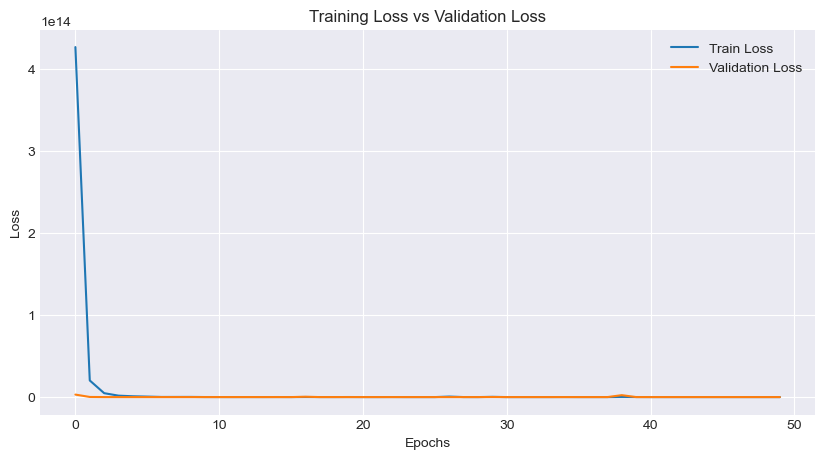

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

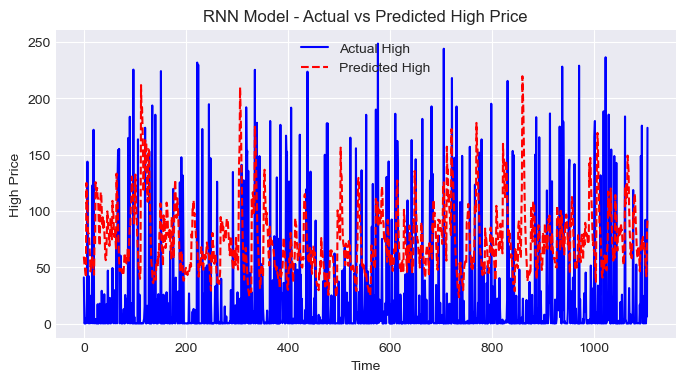

In [147]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label="Actual High", color="blue")
plt.plot(y_pred, label="Predicted High", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("High Price")
plt.title("RNN Model - Actual vs Predicted High Price")
plt.legend()
plt.grid()
plt.show()

### LSTM

In [148]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
trend_scaled = scaler.fit_transform(train_df[["high"]])

# 创建 LSTM 训练数据
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(trend_scaled, time_steps=10)

# 训练 LSTM 模型
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(10, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16)

# 预测
X_test, y_test = create_sequences(scaler.transform(test_df[["high"]]), time_steps=10)
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)  # 反归一化

Epoch 1/20


/opt/homebrew/Caskroom/miniforge/base/envs/city/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0380
Epoch 2/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0394
Epoch 3/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0405
Epoch 4/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0415
Epoch 5/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0395
Epoch 6/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0391
Epoch 7/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0391
Epoch 8/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0397
Epoch 9/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0385
Epoch 10/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0400
Epoch 11/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0382
Epoch 12/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0395
Epoch 13/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0403
Epoch 14/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0413
Epoch 15/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0384


In [149]:
print(f"X_train dtype: {X_train.dtype}, shape: {X_train.shape}")
print(f"y_train dtype: {y_train.dtype}, shape: {y_train.shape}")

X_train dtype: float64, shape: (10019, 10, 1)
y_train dtype: float64, shape: (10019, 1)


In [150]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 计算评估指标
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
r2 = r2_score(y_test, preds)

# 打印评估结果
print(f" MAE: {mae:.4f}")
print(f" RMSE: {rmse:.4f}")
print(f" MAPE: {mape:.2f}%")
print(f" R² Score: {r2:.4f}")

 MAE: 21.9332
 RMSE: 21.9470
 MAPE: 3449394.71%
 R² Score: -12833.3610


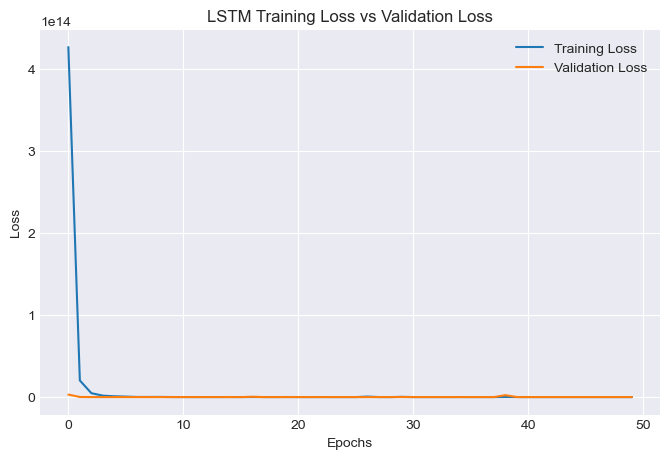

In [151]:
import matplotlib.pyplot as plt

# 绘制训练损失 vs. 验证损失曲线
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training Loss vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

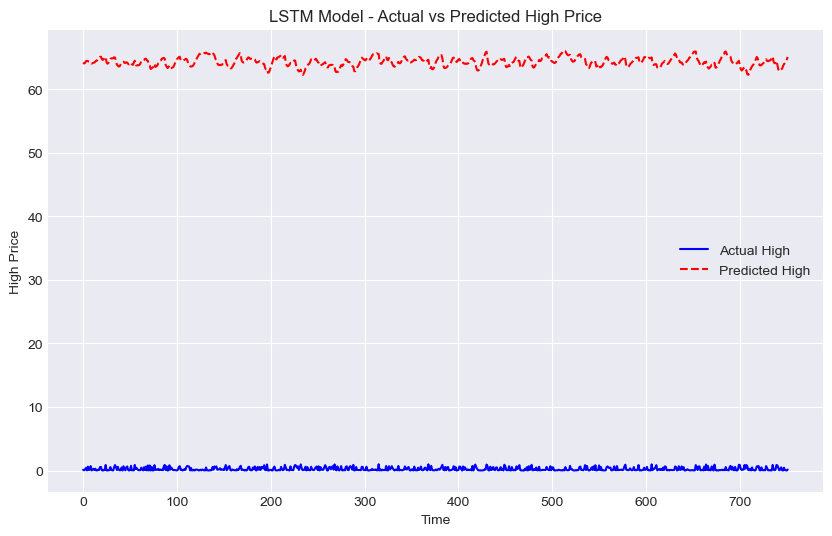

In [59]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label="Actual High", color="blue")
plt.plot(preds, label="Predicted High", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("High Price")
plt.title("LSTM Model - Actual vs Predicted High Price")
plt.legend()
plt.grid()
plt.show()